# Variational Autoencoder

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from time import time
from tqdm.notebook import tqdm, trange


import os

2023-03-06 17:57:35.994231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 17:57:36.136535: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-06 17:57:36.709682: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ubuntu/data/miniconda3/envs/tf2/lib/
2023-03-06 17:57:36.709773: W tensorflow/co

## GPU settings

In [2]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

2023-03-06 17:57:39.125742: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 17:57:39.128141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 17:57:39.139397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 17:57:39.141462: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 17:57:39.143392: I tensorflow/compiler/xla/stream_executo

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
strategy = tf.distribute.MirroredStrategy(['/gpu:0', '/gpu:1']) # gpu distribution strategy
#strategy = tf.distribute.OneDeviceStrategy(device='/CPU:0')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2023-03-06 17:57:40.497578: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 17:57:40.886133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 17:57:40.887623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 17:57:40.888970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there

# Implementing actual model
In this chapter we try to implement the variational image compressing model of the paper on the basis of code written above.

## Encoder

In [4]:
class Encoder(tf.keras.layers.Layer):
    """Encoder network for the VAE."""
    
    def __init__(self, N, M, k, format='channel_last'):
        """Initializes the encoder."""
        
        super(Encoder, self).__init__()
        self.N      = N
        self.M      = M
        self.conv1  = tf.keras.layers.Conv2D(self.N, k, strides=2, padding='same', data_format=format)
        self.conv2  = tf.keras.layers.Conv2D(self.N, k, strides=2, data_format=format)
        self.conv3  = tf.keras.layers.Conv2D(self.N, k, strides=2, data_format=format)
        self.conv4  = tf.keras.layers.Conv2D(self.M, k, strides=1, data_format=format)
        self.gdn1   = tfc.layers.GDN()
        self.gdn2   = tfc.layers.GDN()
        self.gdn3   = tfc.layers.GDN()
    
    def call(self, inputs):
        """Forward pass of the encoder."""
        x = self.conv1(inputs)
        x = self.gdn1(x)
        x = self.conv2(x)
        x = self.gdn2(x)
        x = self.conv3(x)
        x = self.gdn3(x)
        z = self.conv4(x)
        del x
        return z

## Hyperprior

In [5]:
class H_a(tf.keras.layers.Layer):
    """Encoder network for the Hyperprior."""
    
    def __init__(self, N, k1, k2, format):
        """Initializes the encoder."""
        
        super(H_a, self).__init__()
        self.N      = N

        self.conv1  = tf.keras.layers.Conv2D(self.N, k1, strides=1, activation='relu', data_format=format)
        self.conv2  = tf.keras.layers.Conv2D(self.N, k1, strides=1, activation='relu', data_format=format)
        self.conv3  = tf.keras.layers.Conv2D(self.N, k2, strides=2, data_format=format)

    def call(self, inputs):
        """Forward pass of the encoder."""
        x = tf.abs(inputs)
        x = self.conv1(x)
        x = self.conv2(x)
        z = self.conv3(x)
        return z


class H_s(tf.keras.layers.Layer):
    """Decocer network for the Hyperprior."""
    
    def __init__(self, N, M, k1, k2, format):
        """Initializes the decoder."""
        
        super(H_s, self).__init__()
        self.N      = N
        self.M      = M
        
        self.conv1  = tf.keras.layers.Conv2DTranspose(self.N, k2, strides=2, activation='relu', data_format=format)
        self.conv2  = tf.keras.layers.Conv2DTranspose(self.N, k1, strides=1, activation='relu', data_format=format)
        self.conv3  = tf.keras.layers.Conv2DTranspose(self.M, k1, strides=1, activation='relu', data_format=format)

    def call(self, inputs):
        """Forward pass of the decoder."""
        x = self.conv1(inputs)
        x = self.conv2(x)
        z = self.conv3(x)
        return z

## Entropy model

In [6]:
def indexes(i):
    return i+1e-2

def get_indexed_emodel(num_scales):
    return tfc.LocationScaleIndexedEntropyModel(
        prior_fn=tfc.NoisyNormal,
        num_scales=num_scales,
        scale_fn = indexes,
        coding_rank=1,
     )

def get_batched_emodel(batch_shape=()):
    return tfc.ContinuousBatchedEntropyModel(
        prior=tfc.distributions.NoisyDeepFactorized(batch_shape=batch_shape),
        coding_rank=1
    )


## Decoder

In [44]:
class Decoder(tf.keras.layers.Layer):
    """Encoder network for the VAE."""
    
    def __init__(self, N, k, c, format):
        """Initializes the encoder."""
        
        super(Decoder, self).__init__()
        self.N      = N
        self.conv1  = tf.keras.layers.Conv2DTranspose(self.N, k, strides=1, data_format=format)
        self.conv2  = tf.keras.layers.Conv2DTranspose(self.N, k, strides=2, data_format=format)
        self.conv3  = tf.keras.layers.Conv2DTranspose(self.N, k, strides=2, data_format=format)
        self.conv4  = tf.keras.layers.Conv2DTranspose(c, k, strides=2, data_format=format, output_padding=(1, 1))
        self.gdn1   = tfc.layers.GDN(inverse=True, data_format=format)
        self.gdn2   = tfc.layers.GDN(inverse=True, data_format=format)
        self.gdn3   = tfc.layers.GDN(inverse=True, data_format=format)
    
    def call(self, inputs):
        """Forward pass of the decoder."""
        x = self.conv1(inputs)
        x = self.gdn1(x)
        x = self.conv2(x)
        x = self.gdn2(x)
        x = self.conv3(x)
        x = self.gdn3(x)
        z = self.conv4(x)
        return z

## Full model

In [21]:
class Balle(tf.keras.Model):
    """Encoder network for the VAE."""
    
    def __init__(self, N, M, k1, k2, c, format):
        """Initializes the encoder."""
        
        super(Balle, self).__init__()

        self.iemodel = get_indexed_emodel(19)
        self.bemodel = get_batched_emodel(())
        self.encoder = Encoder(N, M, k2, format)
        self.decoder = Decoder(N, k2, c, format)
        self.H_a     = H_a(N, k1, k2, format)
        self.H_s     = H_s(N, M, k1, k2, format)


    def call(self, inputs, training = True):

        y = self.encoder(inputs)
        z = self.H_a(y)
        z_tilde, rate_b = self.bemodel(z, training=training)
        sigma = self.H_s(z_tilde)

        y_tilde, rate_i = self.iemodel(y, sigma, training=training)

        x_tilde = self.decoder(y_tilde)

        return x_tilde, rate_i, rate_b
    

class Balle_ff(tf.keras.Model):
    """Encoder network for the VAE."""
    
    def __init__(self, N, M, k1, k2, c, format):
        """Initializes the encoder."""
        
        super(Balle_ff, self).__init__()

        #self.iemodel = get_indexed_emodel(5)
        self.bemodel = get_batched_emodel((19, 19))
        self.encoder = Encoder(N, M, k2, format)
        self.decoder = Decoder(N, k2, c, format)
        self.H_a     = H_a(N, k1, k2, format)
        self.H_s     = H_s(N, M, k1, k2, format)


    def call(self, inputs, training = True):

        y = self.encoder(inputs)

        y_tilde, rate_i = self.bemodel(y, training=training)

        x_tilde = self.decoder(y_tilde)

        return x_tilde, rate_i

# Functions

In [8]:
def read_data_numpy(data_path, format='channels_last'):
    """Read data from file and return a numpy array."""
    with open(data_path, 'rb') as f:
        # read data from file
        X = np.fromfile(f, dtype=np.uint8)
        # reshape data to (num_images, 3, 96, 96)
        X = np.reshape(X, (-1, 3, 96, 96))
        # transpose data to (num_images, 96, 96, 3) to match the image format
        # NOTE that tensorflow may use a different image format (e.g., channels_first: (num_images, 3, 96, 96))
        if format=='channels_last':
            return np.transpose(X, (0, 3, 2, 1))
        elif format=='channels_first':
            return np.transpose(X, (0, 1, 3, 2))
        else:
            print('unrecognized option "'+format+'"')
            return None
    

def visualize_images(images, format):
    """Visualize images in a grid of 4 rows x 4 columns."""
    # Create a list of 16 images by random sampling from the dataset first dimension without replacement
    image_list = [images[i] for i in np.random.choice(images.shape[0], 16, replace=False)]
    if format=='channels_first':
        image_list = [np.transpose(image, (1, 2, 0)) for image in image_list]
    
    # check if the images are normalized
    norm = np.max(image_list) <= 1.0

    # Create a 4x4 grid of images
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if norm:
            ax.imshow(image_list[i]) # no need to convert to uint8
        else:
            ax.imshow(image_list[i].astype(np.uint8)) # convert to uint8 for visualization
        ax.axis('off')

    # Show the plot
    plt.show()

# Constants

In [9]:
DATA_FOLDER = "../data/stl10/stl10_binary/"
DATA_FILE   = "unlabeled_X.bin"

TRAINING_SET_SIZE      = 40_000 # 80,000 images for training -> 20,000 images for validation
VALIDATION_SET_SIZE    = 10_000
BATCH_SIZE_PER_REPLICA = 64 # batch size per gpu replica (e.g., 64 for 1 gpu, 128 for 2 gpus, etc.)
EPOCHS                 = 50


# Code for training

### Load data

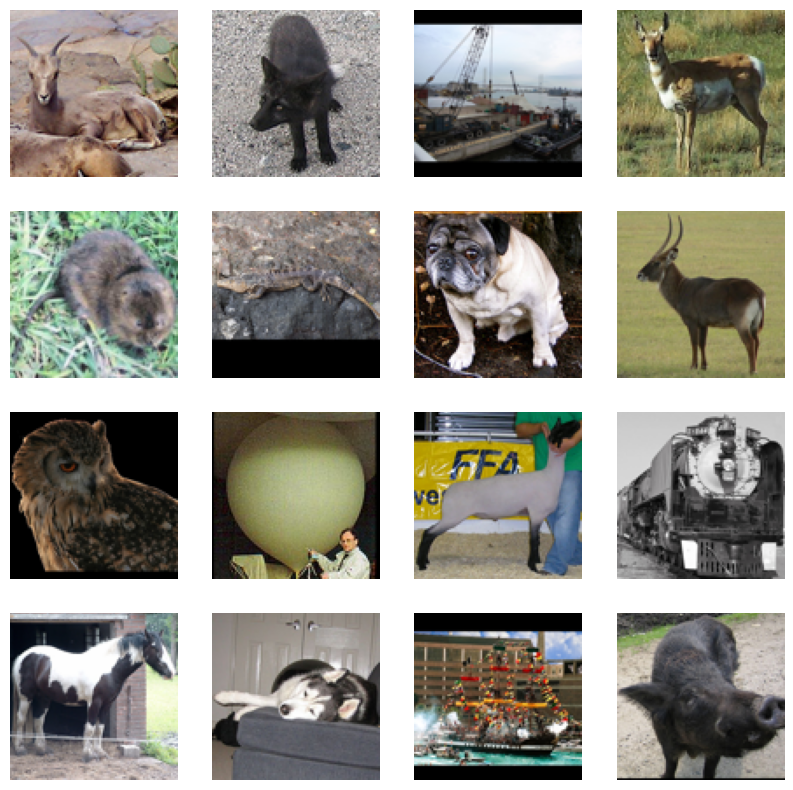

(100000, 96, 96, 3)


In [10]:
data_path = os.path.join(DATA_FOLDER, DATA_FILE)
ch_format = 'channels_last'

data = read_data_numpy(data_path, ch_format)
data = data.astype('float32') #/ 255.0

visualize_images(data, ch_format)
print(data.shape)

### Split train and test data

In [11]:
train_images = data[:TRAINING_SET_SIZE]
test_images  = data[TRAINING_SET_SIZE:TRAINING_SET_SIZE+VALIDATION_SET_SIZE]

buffer_size       = len(train_images) # buffer size for shuffling
global_batch_size = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync # global batch size (in our case 2gpu * BATCH_SIZE_PER_REPLICA)

# create train and test datasets using tf.data API

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(global_batch_size)
test_dataset  = tf.data.Dataset.from_tensor_slices(test_images).batch(global_batch_size)

In [12]:
train_dataset_dist = strategy.experimental_distribute_dataset(train_dataset)
test_dataset_dist  = strategy.experimental_distribute_dataset(test_dataset)

del train_dataset, test_dataset

2023-03-06 18:06:02.071379: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 40000
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 96
        }
        dim {
          size: 96
        }
        dim {
          size: 3
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT


### Create model

In [23]:
# create a VAE model using the strategy scope to distribute the model on multiple gpus
with strategy.scope():
    vae       = Balle(N=128, M=192, k1=3, k2=3, c=3, format=ch_format)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) 

In [13]:
with strategy.scope():
    for inputs in train_dataset_dist:
        test = inputs
        break


In [14]:
test= test.values[0]

In [35]:
with tf.device('CPU'):
    enc = Encoder(N=128, M=192, k=3, format='channels_last')
    encoded = enc(test, training=False)
encoded

<tf.Tensor: shape=(64, 9, 9, 192), dtype=float32, numpy=
array([[[[-2.73730588e+00,  3.82928824e+00, -2.21746874e+00, ...,
           2.67303252e+00,  7.41072714e-01,  2.27660751e+00],
         [-7.37721205e-01,  2.92959714e+00, -2.83427000e+00, ...,
           2.84671164e+00,  3.82586330e-01,  7.35800922e-01],
         [-1.08587921e+00,  2.31573462e+00, -2.26259828e+00, ...,
           2.54704380e+00, -1.05383050e+00,  1.53983366e+00],
         ...,
         [-1.83964360e+00,  1.72884822e+00, -1.38895452e+00, ...,
           2.06735587e+00, -3.39645654e-01,  3.35539556e+00],
         [-1.15938389e+00,  2.55942297e+00, -3.06083989e+00, ...,
           2.34193802e+00, -6.71476364e-01,  2.63734865e+00],
         [-1.84194255e+00,  1.96273291e+00, -1.49806845e+00, ...,
           2.04785466e+00,  1.14280486e+00,  2.49660563e+00]],

        [[-2.34922075e+00,  2.40538549e+00, -1.16827285e+00, ...,
           2.13093710e+00,  1.78307697e-01, -5.36814556e-02],
         [-2.25091672e+00,  3.0

In [35]:
iemod = tfc.LocationScaleIndexedEntropyModel(
        prior_fn=tfc.NoisyNormal,
        num_scales= 50,
        scale_fn = indexes,
        coding_rank=2,
     )
y_tilde, rate = iemod(encoded, encoded, training=True)

In [36]:
rate

<tf.Tensor: shape=(64, 192), dtype=float32, numpy=
array([[ 920.28143, 1212.2677 ,        nan, ...,        nan, 1178.1243 ,
        1534.8798 ],
       [ 896.2532 , 1193.9736 ,        nan, ...,        nan, 1194.2621 ,
        1405.3711 ],
       [       nan,        nan,        nan, ...,        nan, 1102.8801 ,
        1298.0446 ],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
        1424.1112 ],
       [       nan, 1103.4207 ,        nan, ...,        nan,        nan,
        1300.5631 ],
       [       nan,        nan,        nan, ...,        nan,        nan,
        1458.63   ]], dtype=float32)>

In [45]:
with tf.device('CPU'):
    de = Decoder(N=128, k=3, c=3, format='channels_last')
    decoded = de(encoded, training=False)
decoded

<tf.Tensor: shape=(64, 96, 96, 3), dtype=float32, numpy=
array([[[[ 1.14648163e-01, -3.46269384e-02,  5.11650257e-02],
         [ 4.17420231e-02, -8.63816068e-02,  4.46129926e-02],
         [ 4.09053229e-02,  1.67443715e-02, -1.78070948e-03],
         ...,
         [ 1.53620224e-02,  5.03831776e-03,  3.34732868e-02],
         [ 6.52348027e-02,  5.14209531e-02, -6.97845742e-02],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 1.19642273e-01, -1.56059237e-02, -5.92145312e-04],
         [-3.60262319e-02,  2.32487265e-02,  7.05948845e-02],
         [ 4.26466241e-02, -4.76543345e-02, -5.23083843e-02],
         ...,
         [ 4.40167002e-02,  1.79235414e-02,  3.43462303e-02],
         [-7.82526098e-03,  1.27762742e-02,  1.22306878e-02],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[-1.70879513e-01, -3.81946452e-02, -1.06875584e-01],
         [-9.72858369e-02,  7.27137625e-02,  4.88810986e-02],
         [ 1.87343974e-02,  5.68708703e-02,

In [48]:
with tf.device('CPU'):
    ha = H_a(128, 3, 3, format='channels_last')
    result = ha(encoded, training=False)
result

<tf.Tensor: shape=(64, 2, 2, 128), dtype=float32, numpy=
array([[[[ 1.5472558 ,  2.1320033 , -0.6954674 , ..., -0.15996917,
           1.1919583 , -1.9816616 ],
         [ 1.5614969 ,  2.0636437 , -1.1100771 , ..., -0.51933473,
           1.8142918 , -2.203015  ]],

        [[ 1.2649449 ,  2.1734447 , -1.4907289 , ..., -0.44094843,
           1.684974  , -1.5181243 ],
         [ 0.98259676,  1.8130963 , -1.3596208 , ..., -0.309891  ,
           0.84943634, -2.0623987 ]]],


       [[[ 1.2734998 ,  1.2690748 , -1.3346769 , ...,  0.00920018,
           1.3846844 , -1.337449  ],
         [ 1.1643237 ,  1.4559098 , -1.3865789 , ..., -0.03492911,
           1.4054039 , -1.1991208 ]],

        [[ 1.2912638 ,  1.6169825 , -0.7441878 , ..., -0.4314866 ,
           1.166408  , -1.7874726 ],
         [ 1.7589555 ,  1.612279  , -0.5276201 , ..., -0.27021265,
           1.0478461 , -1.5181818 ]]],


       [[[ 0.80729735,  1.616353  , -0.6450799 , ..., -0.375581  ,
           1.6916412 , -1.073172

In [38]:
bemod = get_batched_emodel(())
bemod(result, training=True)

(<tf.Tensor: shape=(2, 7, 7, 128), dtype=float32, numpy=
 array([[[[-2.94399142e-01,  4.82595414e-01, -1.17030025e-01, ...,
           -1.02539748e-01,  4.19303216e-03,  1.12183914e-01],
          [ 3.41340899e-01,  3.32836747e-01,  3.99663299e-01, ...,
           -1.21051267e-01,  3.38275403e-01, -3.30791771e-02],
          [-1.51580378e-01, -4.62349206e-01,  1.73807517e-01, ...,
           -4.62265044e-01,  4.67777580e-01, -2.21513599e-01],
          ...,
          [ 3.66891474e-01, -3.58220994e-01, -3.28787744e-01, ...,
           -2.23657340e-01, -3.27185273e-01,  5.45492023e-02],
          [ 3.26326698e-01, -8.94062892e-02, -3.81381899e-01, ...,
           -3.72395873e-01, -9.46771353e-02,  3.16881508e-01],
          [-2.89478421e-01, -1.05682023e-01,  1.00531913e-01, ...,
            3.88486296e-01, -5.06275177e-01, -3.01467896e-01]],
 
         [[ 4.27663714e-01,  1.59681514e-01,  3.24673712e-01, ...,
           -3.67437869e-01, -4.10318553e-01,  2.79207379e-01],
          [-1.1

In [49]:
with tf.device('CPU'):
    hs = H_s(128, 192, 3, 3, format='channels_last')
    result = hs(result, training=False)
result

<tf.Tensor: shape=(64, 9, 9, 192), dtype=float32, numpy=
array([[[[2.15642676e-02, 3.10264714e-02, 0.00000000e+00, ...,
          0.00000000e+00, 2.02012192e-02, 4.31421101e-02],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          6.52412400e-02, 1.27798086e-02, 3.32774259e-02],
         [0.00000000e+00, 3.50764878e-02, 0.00000000e+00, ...,
          3.73168997e-02, 0.00000000e+00, 0.00000000e+00],
         ...,
         [5.19904792e-02, 5.98636568e-02, 1.26053514e-02, ...,
          3.97353843e-02, 0.00000000e+00, 7.06099570e-02],
         [1.94225386e-02, 2.79793376e-03, 0.00000000e+00, ...,
          3.82944867e-02, 1.28309503e-02, 2.47096121e-02],
         [4.31237859e-04, 0.00000000e+00, 2.18854379e-02, ...,
          1.54849449e-02, 1.27767585e-02, 1.08195851e-02]],

        [[1.78519003e-02, 0.00000000e+00, 0.00000000e+00, ...,
          1.28967955e-03, 4.56297249e-02, 8.88232067e-02],
         [0.00000000e+00, 8.71075317e-02, 0.00000000e+00, ...,
          

### Training

In [24]:
with strategy.scope():
  @tf.function
  def Loss(inputs, outputs):
    
    return tf.reduce_mean(tf.square(inputs - outputs[0])) + 0.5*(tf.reduce_mean(outputs[1])+tf.reduce_mean(outputs[2])) #

  @tf.function
  def compute_loss(labels, predictions):
    per_example_loss = Loss(labels, predictions)
    return tf.nn.compute_average_loss(per_example_loss, global_batch_size=global_batch_size)

In [25]:
with strategy.scope():
    @tf.function # compile the function to a graph for faster execution
    def train_step(inputs, vae):
        """Train step function."""
        with tf.GradientTape() as tape: # create a tape to record operations
            
            reconstructed, ratei, rateb = vae(inputs) # forward pass
            loss          = Loss(inputs, (reconstructed, ratei, rateb)) # MSE loss (maybe put this in a function)
        gradients = tape.gradient(loss, vae.trainable_variables) # compute gradients    
        optimizer.apply_gradients(zip(gradients, vae.trainable_variables)) # gradient descent
        return loss # return loss for logging
    
    @tf.function
    def val_step(inputs, vae):
        outputs = vae(inputs, training=False) # forward pass
        loss    = Loss(inputs, outputs)       

        return loss 
    
def val_step_dist(inputs, vae, strategy):
    loss = strategy.run(val_step, args=(inputs, vae))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, loss, axis=None)


In [26]:
for epoch in range(EPOCHS):
    total_loss = 0.0 
    num_batches = 0 
    for inputs in tqdm(train_dataset_dist, 'training steps'): 
        loss = strategy.run(train_step, args=(inputs, vae)) # distributed training
        total_loss += strategy.reduce(tf.distribute.ReduceOp.SUM, loss, axis=None) # sum losses across replicas
        num_batches += 1 # count number of batches
    train_loss = total_loss / num_batches # compute average loss
    print('Epoch {} train loss: {}'.format(epoch, train_loss))

    total_loss = 0.0
    num_batches = 0
    for inputs in tqdm(test_dataset_dist, 'validation steps'): 
        
        total_loss += val_step_dist(inputs, vae, strategy) # sum losses across replicas
        num_batches += 1 # count number of batches
    test_loss = total_loss / num_batches # compute average loss
    print('Epoch {} test loss: {}'.format(epoch, test_loss))

training steps: 0it [00:00, ?it/s]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
INFO:tensorflow:batch_all_reduce: 48 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 48 all-reduces with algorithm = nccl, num_packs = 1


2023-03-04 15:50:53.669484: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/location_scale_indexed_entropy_model/NoisyNormal/log_prob/SelectV2_1-1-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-04 15:50:56.585366: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-04 15:50:57.283899: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-04 15:50:59.773394: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f3501287a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-04 15:50:59.773435: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-03-04 15:50:59.773441: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Tesla T4, C

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2023-03-04 15:52:23.735172: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/location_scale_indexed_entropy_model/NoisyNormal/log_prob/SelectV2_1-1-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 0 train loss: 36725.78125


validation steps: 0it [00:00, ?it/s]

Epoch 0 test loss: 13756.91015625


training steps: 0it [00:00, ?it/s]

## Training with model compile and fit

In [17]:
with strategy.scope():
    vae       = Balle(N=128, M=192, k1=3, k2=3, c=3, format=ch_format)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) 

    def loss(inputs, outputs):
        print('outputs:', outputs.shape, '\ninputs:', inputs.shape)
        return tf.reduce_mean(tf.square(inputs - outputs[0])) + 0.5*(tf.reduce_mean(outputs[1])+tf.reduce_mean(outputs[2]))
        

vae.compile(optimizer=optimizer, loss=loss)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [18]:
vae.fit(train_dataset)

2023-03-03 15:03:29.947843: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 8000
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 3
        }
        dim {
          size: 96
        }
        dim {
          size: 96
        }
      }
      shape {
        dim {
          size: 3
        }
        dim {
          size: 96
        }
        dim {
          size: 96
        }
     

outputs: (None, 3, 96, 96) 
inputs: (None, 3, 96, 96)
outputs: (None, 192, 19) 
inputs: (None, 3, 96, 96)
INFO:tensorflow:Error reported to Coordinator: in user code:

    File "/tmp/ipykernel_258252/389013783.py", line 7, in loss  *
        return tf.reduce_mean(tf.square(inputs - outputs[0])) + 0.5*(tf.reduce_mean(outputs[1])+tf.reduce_mean(outputs[2]))

    ValueError: Dimensions must be equal, but are 96 and 192 for '{{node loss_1/sub}} = Sub[T=DT_FLOAT](cond/Identity_2, loss_1/strided_slice)' with input shapes: [?,3,96,96], [192,19].
Traceback (most recent call last):
  File "/home/ubuntu/data/miniconda3/envs/tf/lib/python3.10/site-packages/tensorflow/python/training/coordinator.py", line 293, in stop_on_exception
    yield
  File "/home/ubuntu/data/miniconda3/envs/tf/lib/python3.10/site-packages/tensorflow/python/distribute/mirrored_run.py", line 386, in run
    self.main_result = self.main_fn(*self.main_args, **self.main_kwargs)
  File "/home/ubuntu/data/miniconda3/envs/tf/lib/p

ValueError: in user code:

    File "/home/ubuntu/data/miniconda3/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/tmp/ipykernel_258252/389013783.py", line 7, in loss  *
        return tf.reduce_mean(tf.square(inputs - outputs[0])) + 0.5*(tf.reduce_mean(outputs[1])+tf.reduce_mean(outputs[2]))

    ValueError: Dimensions must be equal, but are 96 and 192 for '{{node loss_1/sub}} = Sub[T=DT_FLOAT](cond/Identity_2, loss_1/strided_slice)' with input shapes: [?,3,96,96], [192,19].


## Testing iemodel

In [10]:
test = tf.random.normal((64, 192, 19, 19))

In [42]:
hs = H_s(128, 192, 3, 3, 'channels_first')
ha = H_a(128, 3, 3, 'channels_first')

z = ha(encoded)
sigma = hs(z)
sigma

<tf.Tensor: shape=(64, 192, 19, 19), dtype=float32, numpy=
array([[[[0.00000000e+00, 7.23905787e-02, 3.11769880e-02, ...,
          2.07987837e-02, 0.00000000e+00, 9.28756129e-03],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.52004361e-02, 0.00000000e+00, 0.00000000e+00],
         [1.27814412e-02, 6.18779585e-02, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 7.59538934e-02, 0.00000000e+00, ...,
          8.33565295e-02, 4.00034264e-02, 2.98643596e-02],
         [0.00000000e+00, 3.60040516e-02, 0.00000000e+00, ...,
          0.00000000e+00, 3.95415276e-02, 0.00000000e+00],
         [0.00000000e+00, 2.97213942e-02, 2.62724664e-02, ...,
          2.32723430e-02, 4.83872369e-02, 1.60696320e-02]],

        [[2.89189070e-02, 5.52558303e-02, 1.51699297e-02, ...,
          2.60969903e-02, 0.00000000e+00, 6.94776094e-03],
         [0.00000000e+00, 1.75969414e-02, 6.75767660e-06, ...,
        

In [48]:
iemod = tfc.LocationScaleIndexedEntropyModel(
        prior_fn=tfc.NoisyNormal,
        num_scales= 256,
        scale_fn = indexes,
        coding_rank=0,
     )
result, rate = iemod(encoded, sigma, training=True)
rate

<tf.Tensor: shape=(64, 192, 19, 19), dtype=float32, numpy=
array([[[[           nan, 8.23219204e+00, 3.49355011e+02, ...,
          3.24217188e+03,            nan, 1.98797734e+04],
         [           nan,            nan,            nan, ...,
          5.33444824e+03,            nan,            nan],
         [2.05837988e+03, 2.58976318e+02,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [0.00000000e+00, 3.59893684e+01,            nan, ...,
          1.12104902e+01, 8.90300720e+02, 3.28370996e+03],
         [           nan, 1.01733344e+03,            nan, ...,
                     nan, 2.05822258e+01,            nan],
         [           nan, 3.99195630e+03, 5.00311328e+03, ...,
          1.36561499e+03, 5.55914246e+02, 2.80199121e+03]],

        [[4.29011328e+03, 7.40786987e+02, 8.68036230e+03, ...,
          1.36884863e+03,            nan, 1.63891406e+05],
         [           nan, 7.92375732e+03, 2.68902175e+10, ...,
        

In [46]:
sigma[0, 0]

<tf.Tensor: shape=(19, 19), dtype=float32, numpy=
array([[0.        , 0.07239058, 0.03117699, 0.        , 0.05740443,
        0.        , 0.04960363, 0.        , 0.05611933, 0.        ,
        0.05604941, 0.        , 0.04607544, 0.        , 0.06205181,
        0.        , 0.02079878, 0.        , 0.00928756],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.01520044, 0.        , 0.        ],
       [0.01278144, 0.06187796, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ,